# Outline: #
- Initialize
    - Imports
    - Definitions, variables, and dictionaries

In [1]:
#%matplotlib widget
%matplotlib inline

import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
import pandas as pd
import time
import datetime

import matplotlib.animation as animation
from IPython import display

from matplotlib.animation import PillowWriter

print('all libraries imported! c;')

all libraries imported! c;


In [2]:
# close plots
for i in range(1000):
    plt.close(i)

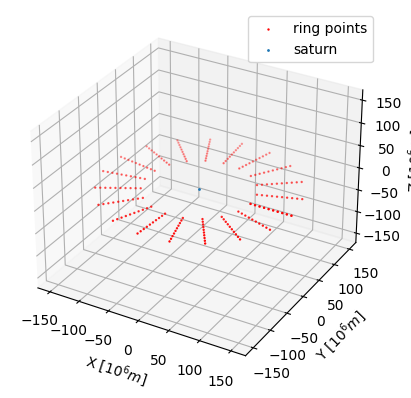

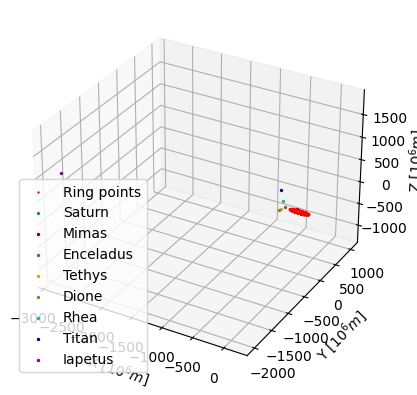

[      0.           22860.82722084   45721.65444167   68582.48166251
   91443.30888334  114304.13610418  137164.96332502  160025.79054585
  182886.61776669  205747.44498753  228608.27220836  251469.0994292
  274329.92665003  297190.75387087  320051.58109171  342912.40831254
  365773.23553338  388634.06275421  411494.88997505  434355.71719589
  457216.54441672  480077.37163756  502938.19885839  525799.02607923
  548659.85330007  571520.6805209   594381.50774174  617242.33496258
  640103.16218341  662963.98940425  685824.81662508  708685.64384592
  731546.47106676  754407.29828759  777268.12550843  800128.95272926
  822989.7799501   845850.60717094  868711.43439177  891572.26161261
  914433.08883344  937293.91605428  960154.74327512  983015.57049595
 1005876.39771679 1028737.22493763 1051598.05215846 1074458.8793793
 1097319.70660013 1120180.53382097 1143041.36104181 1165902.18826264
 1188763.01548348 1211623.84270431 1234484.66992515 1257345.49714599
 1280206.32436682 1303067.15158766 1

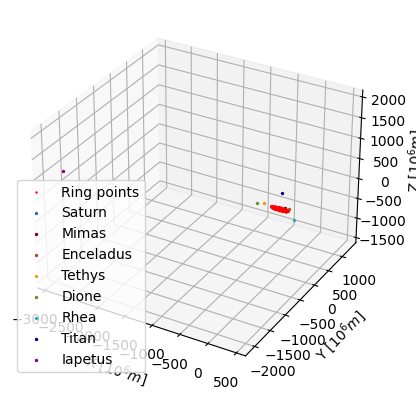

In [71]:
'''README
    Units:
Force: N
Distance: Mm (megameters)
Mass: Gg (Gigagrams)        

m   --> Mm  *e-6
kg  --> Gg  *e-6

Constants in new units from SI units:
Gravitational constant 6.6726e-11  N m2 kg-2        --> 6.6726e-11  N Mm2 Gg-2
Saturn Mass            5.6834e26   kg               --> 5.6834e20   Gg

'''
def rotation_matrix(axis, theta):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    axis = np.asarray(axis)
    axis = axis / np.sqrt(np.dot(axis, axis))
    a = np.cos(theta / 2.0)
    b, c, d = -axis * np.sin(theta / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])
def set_axes_equal(ax):
    """
    Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    """

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

def initParameters(mode): #WHAT IS A GOOD WAY TO PASS MANY PARAMETERS INTO AN INITIALIZATION FUNCTION??
    global ParamsDict
    ParamsDict = {

        'numberOfMoons': mode[0].count(1),
        'moonsList': mode[0],
        'moonsOrbitShape': mode[1],
        'moonsOrbitType': mode[2],
        'ringParticleNumber': mode[3],
        'initialDistributionType': mode[4],
        'ringLimits': mode[5]
    }
    return None
def calculateRingPlaneDir(): #calculates ring elements and adds them to ConstantsDict
    v1 = ConstantsDict.get('AegaeonElements')[0][0:3]
    v2 = ConstantsDict.get('AegaeonElements')[1][0:3]
    v1 = v1/np.sqrt(np.dot(v1,v1))
    v2 = v2/np.sqrt(np.dot(v2,v2))
    normalVector = np.cross(v1, v2)
    angle = np.arccos(np.dot(normalVector, [0,0,1])/np.sqrt(np.dot(normalVector,normalVector)))
    node = np.cross([0,0,1], normalVector)
    node = node/np.sqrt(np.dot(node,node))
    ConstantsDict.update({'ringAngle': angle, 'ringNode': node})
    return None
def circularizeMoonElements(debug=[]):
    GravConst = ConstantsDict.get('Gravitational Constant')
    SaturnMass = ConstantsDict.get('Saturn Mass')
    periods = np.array(MoonsDict.get('period'))
    radius = np.cbrt(GravConst*SaturnMass*periods**2/(4*np.pi**2))
    radius = radius*1e-4 #conversion factor for wacky units
    MoonsDict.update({'radius': radius})
    velocities = np.sqrt(GravConst*SaturnMass/radius)
    velocities = velocities*1e-6 #conversion factor for wacky units
    elements = MoonsDict.get('elements')
    if 'elementDiff' in debug:
        print('Old Elements: {}'.format(elements))
    for i in range(len(elements)):
        oPos = elements[i][0:3]
        nPos = oPos*radius[i]/np.sqrt(np.dot(oPos,oPos)) #circularize positions
        elements[i][0:3] = nPos
        oVel = elements[i][3:6]
        nVel = -oPos*np.dot(oPos,oVel)+oVel*np.dot(oPos,oPos) #using vector triple product
        nVel = nVel*velocities[i]/np.sqrt(np.dot(nVel,nVel)) #set new velocity magnitude and direction
        elements[i][3:6] = nVel
    if 'elementDiff' in debug:
        print('Circularized Elements: {}'.format(elements))
    MoonsDict.update({'elements': elements,'radii': radius})
    return None
def calcBodyPositions(time): #returns array of positions of each body at given time. Only available under restricted orbit type
    periods = MoonsDict.get('period')
    trueAnomalies = MoonsDict.get('moonTrueAnomalies')
    moonInclinations = MoonsDict.get('moonInclinations')
    moonNodes = MoonsDict.get('moonNodes')
    moonMasses = MoonsDict.get('mass')
    saturnMass = ConstantsDict.get('Saturn Mass')
    radii = MoonsDict.get('radii')
    #calculate moons positions
    positions = np.zeros((0,3))
    saturnDisplacement = np.zeros((1,3))
    for i in range(len(periods)):
        rotationMatrix = rotation_matrix(moonNodes[i],moonInclinations[i])
        inPlanePos = radii[i]*np.array([np.cos(2*np.pi*time/periods[i] + trueAnomalies[i]), np.sin(2*np.pi*time/periods[i] + trueAnomalies[i]),0])
        pos = np.matmul(rotationMatrix, inPlanePos)
        pos = np.array([pos])
        positions = np.append(positions, pos,0)
        newDisplacement = -pos*moonMasses[i]/saturnMass
        saturnDisplacement = saturnDisplacement + newDisplacement*(saturnMass + moonMasses[i])
    saturnDisplacement = saturnDisplacement/(saturnMass + np.sum(moonMasses))
    return positions, saturnDisplacement

def removeNetMomentum(debug=[]):
    #fill in when doing n-body/elliptical simulations
    return None
def initConstants(localMode):
    global ConstantsDict
    match localMode:
        case 'restricted':
            ConstantsDict = {
                'Gravitational Constant': 6.6726e-11,           #unreferenced
                'Saturn Mass': 5.6834e20,                       #from Horizon's Ephemeris, in gigagrams
                'Saturn Radius': 5.8232e1,                      #from Horizon's Ephemeris, in megameters
                'SaturnElements': np.array([ 1.95683334e-01, -2.07967708e-01,  8.89114822e-02,  1.00287582e-06,
        7.10261281e-07, -4.62358562e-07,  9.97617585e-07,  2.99078228e-01,
        2.48285806e-08]),
                'AegaeonElements': np.array([[ 1.62925749e+05,  2.62721373e+04, -2.95455149e+04,
        -3.33490571e+00,  1.31494109e+01, -6.56677155e+00,
         5.59234531e-01,  1.67654295e+05, -2.30249816e-02],
       [-2.38713706e+04,  1.47623071e+05, -7.50370575e+04,
        -1.48591023e+01, -1.34028152e+00,  2.14131733e+00,
         5.58089452e-01,  1.67311008e+05, -2.30249816e-02]]) #Aegaeon Elements to calculate ring angular momentum vector direction
            }
    calculateRingPlaneDir() #calculates ring elements and adds them to ConstantsDict
    return None

def initMoonsDictionary(mode,debug=[]):
    global MoonsDict
    match mode:
        case 'circularMimas':
            MoonsDict = {
                'name': ['Mimas'],
                'mass': [3.75094e13],
                'semiMajorAxis': [186], #JPL Mean elements
                'elements': np.array([[-1.12774495e+02,  1.37769404e+02, -6.15442605e+01,
        -1.11522197e-02, -7.32502779e-03,  4.48190526e-03,
         6.28360667e-04,  1.88377789e+02, -1.44997560e-04]]),
                'period': [81202.91773558],
            }
            circularizeMoonElements(debug)
            removeNetMomentum(debug) #Fill in later
        case 'circular':
            MoonsDict = {
                'name': ['Mimas', 'Enceladus', 'Tethys', 'Dione', 'Rhea', 'Titan', 'Iapetus'],
                'color': ['maroon', 'sienna', 'goldenrod', 'olivedrab', 'lightseagreen', 'darkblue', 'purple'],
                'mass': [3.75094e13, 1.080318e14, 6.174959e14, 1.0954868e15, 2.3064854e15, 1.345180354e17, 1.8056591e15], #unreferenced and also, masses are in gigagrams
                'semiMajorAxis1': [186, 238.4, 295, 377.7, 527.2, 1221.9, 3561.7], #JPL Mean elements
                'period': np.array([  81202.91773558,  118063.58844184,  162660.74331798,
        235823.79311927,  389307.62992529, 1373922.70607731,
       6835397.33903   ]),
                'elements': np.array([[-1.12774495e+02,  1.37769404e+02, -6.15442605e+01,
        -1.11522197e-02, -7.32502779e-03,  4.48190526e-03,
         6.28360667e-04,  1.88377789e+02, -1.44997560e-04],
       [-2.37504674e+02,  4.38287375e+00,  2.07516961e+01,
         3.41979024e-04, -1.11706534e-02,  5.81982969e-03,
         7.95382958e-04,  2.38449812e+02, -3.94625721e-05],
       [-2.16465458e+02, -1.68425522e+02,  1.07915081e+02,
         7.61827803e-03, -7.81392642e-03,  3.11628009e-03,
         9.83138032e-04,  2.94737367e+02,  1.10750003e-05],
       [-1.78507630e+02, -2.87400621e+02,  1.67876593e+02,
         8.79997358e-03, -4.55139058e-03,  1.52685661e-03,
         1.25982456e-03,  3.77685903e+02, -1.71212616e-05],
       [-4.20266046e+02,  2.97492400e+02, -1.13714237e+02,
        -5.06391274e-03, -5.78324263e-03,  3.56885352e-03,
         1.75891800e-03,  5.27310350e+02,  3.58498357e-06],
       [-7.76758503e+02,  9.02355914e+02, -3.89577017e+02,
        -4.27821397e-03, -2.78299533e-03,  1.85622920e-03,
         4.17870777e-03,  1.25274507e+03,  7.08384752e-05],
       [-2.93445621e+03, -1.90942637e+03,  1.04088540e+03,
         1.82417062e-03, -2.59469624e-03,  2.47649163e-04,
         1.21832589e-02,  3.65244914e+03, -3.85475538e-05]])
            }
            circularizeMoonElements(debug)
            removeNetMomentum(debug) #Fill in later
        case 'elliptical':
            MoonsDict = {
                'name': ['Mimas', 'Enceladus', 'Tethys', 'Dione', 'Rhea', 'Titan', 'Iapetus'],
                'color': ['maroon', 'sienna', 'goldenrod', 'olivedrab', 'lightseagreen', 'darkblue', 'purple'],
                'mass': [3.75094e13, 1.080318e14, 6.174959e14, 1.0954868e15, 2.3064854e15, 1.345180354e17, 1.8056591e15], #unreferenced and also, masses are in gigagrams
                'period': np.array([  81202.91773558,  118063.58844184,  162660.74331798,
        235823.79311927,  389307.62992529, 1373922.70607731,
       6835397.33903   ]),
                'elements': np.array([[-1.12774495e+02,  1.37769404e+02, -6.15442605e+01,
        -1.11522197e-02, -7.32502779e-03,  4.48190526e-03,
         6.28360667e-04,  1.88377789e+02, -1.44997560e-04],
       [-2.37504674e+02,  4.38287375e+00,  2.07516961e+01,
         3.41979024e-04, -1.11706534e-02,  5.81982969e-03,
         7.95382958e-04,  2.38449812e+02, -3.94625721e-05],
       [-2.16465458e+02, -1.68425522e+02,  1.07915081e+02,
         7.61827803e-03, -7.81392642e-03,  3.11628009e-03,
         9.83138032e-04,  2.94737367e+02,  1.10750003e-05],
       [-1.78507630e+02, -2.87400621e+02,  1.67876593e+02,
         8.79997358e-03, -4.55139058e-03,  1.52685661e-03,
         1.25982456e-03,  3.77685903e+02, -1.71212616e-05],
       [-4.20266046e+02,  2.97492400e+02, -1.13714237e+02,
        -5.06391274e-03, -5.78324263e-03,  3.56885352e-03,
         1.75891800e-03,  5.27310350e+02,  3.58498357e-06],
       [-7.76758503e+02,  9.02355914e+02, -3.89577017e+02,
        -4.27821397e-03, -2.78299533e-03,  1.85622920e-03,
         4.17870777e-03,  1.25274507e+03,  7.08384752e-05],
       [-2.93445621e+03, -1.90942637e+03,  1.04088540e+03,
         1.82417062e-03, -2.59469624e-03,  2.47649163e-04,
         1.21832589e-02,  3.65244914e+03, -3.85475538e-05]])#Horizons System Ephemeris Data for 2000-01-01
            }
    return None

def initRings(mode, debug=[]): #creates correctly oriented ring distribution using of shape (3, #of particles)
    ringsPartNum = mode[0]
    ringsType = mode[1]
    ringLimits = mode[2]
    match ringsType:
        case 'flatRadial':
            saturnMass = ConstantsDict.get('Saturn Mass')
            gravConst = ConstantsDict.get('Gravitational Constant')
            radiiNum = int(np.ceil(ringsPartNum/ringLimits[2]))
            angles = np.linspace(0,2*np.pi,ringLimits[2])
            radii = np.linspace(ringLimits[0],ringLimits[1], radiiNum)
            
            velocities = np.sqrt(gravConst*saturnMass/radii)*1e-6
            initRArray = np.zeros((3,0))
            initVArray = np.zeros((3,0))
            for i in range(radiiNum):
                array1 = radii[i]*np.array([np.cos(angles),np.sin(angles),np.zeros(len(angles))])
                array2 = velocities[i]*np.array([-np.sin(angles),np.cos(angles),np.zeros(len(angles))])
                if 'arrayShapes' in debug:
                    print('array1 shape: {}'.format(np.shape(array1)))
                    print('array2 shape: {}'.format(np.shape(array2)))
                    print('initRArray shape: {}'.format(np.shape(initRArray)))
                    print('initVArray shape: {}'.format(np.shape(initVArray)))
                initRArray = np.append(initRArray, array1,1)
                initVArray = np.append(initVArray, array2,1)
            if 'init' in debug:
                ax = plt.figure().add_subplot(projection='3d')
                ax.scatter(initRArray[0], initRArray[1], initRArray[2], s=0.5, label='ring points',color='red')
                saturnPos = ConstantsDict.get('SaturnElements')[0:3]
                ax.scatter(*saturnPos, s = 1, label='saturn')

                ax.legend()
                ax.set_xlabel('X [$10^6 m$]')
                ax.set_ylabel('Y [$10^6 m$]')
                ax.set_zlabel('Z [$10^6 m$]')
                set_axes_equal(ax)
                plt.show()
        case 'flatArea':
            print('kekw') #create constant area distribution WIP
    axis = ConstantsDict.get('ringNode')
    angle = ConstantsDict.get('ringAngle')
    rotationMatrix = rotation_matrix(axis, angle)
    outRArray = np.matmul(rotationMatrix, initRArray)
    outVArray = np.matmul(rotationMatrix, initVArray)
    if 'out' in debug:
        ax = plt.figure().add_subplot(projection='3d')
        ax.scatter(outRArray[0], outRArray[1], outRArray[2], s=0.5, label='Ring points',color='red')
        saturnPos = ConstantsDict.get('SaturnElements')[0:3]
        ax.scatter(*saturnPos, s = 2, label='Saturn')
        names = MoonsDict.get('name')
        colors = MoonsDict.get('color')
        elements = MoonsDict.get('elements')
        for i in range(len(colors)):
            ax.scatter(*elements[i][0:3], s = 2, label=names[i], color=colors[i])
        ax.legend()
        ax.set_xlabel('X [$10^6 m$]')
        ax.set_ylabel('Y [$10^6 m$]')
        ax.set_zlabel('Z [$10^6 m$]')
        set_axes_equal(ax)
        plt.show()
    return outRArray, outVArray

def initOrbitType(mode,debug=[]): #updates dicts to accommodate restricted orbit type
    match mode:
        case 'restricted':
            elements = MoonsDict.get('elements')
            moonInclinations = np.array([])
            moonTrueAnomalies = np.array([])
            moonNodes = np.zeros((0,3))
            for i in range(len(elements)):
                pos = elements[i][0:3]
                vel = elements[i][3:6]
                normal = np.cross(pos,vel)
                angle = np.arccos(np.dot(normal, [0,0,1])/np.sqrt(np.dot(normal,normal)))
                moonInclinations = np.append(moonInclinations, angle)
                node = np.cross([0,0,1],normal)
                node = node/np.sqrt(np.dot(node,node))
                node = np.array([node])
                moonNodes = np.append(moonNodes,node,0)
                rotationMatrix = rotation_matrix(node[0], -angle)
                inPlanePos = np.matmul(rotationMatrix, pos)
                #print(inPlanePos)
                trueAnomaly = np.arctan2(inPlanePos[1],inPlanePos[0])
                moonTrueAnomalies = np.append(moonTrueAnomalies, trueAnomaly)
                
            if 'moonNodesAngles' in debug:
                print(moonInclinations)
                print(np.shape(moonNodes))
                print('node vectors: {}'.format(moonNodes))
                print('true anomaly angles: {}'.format(moonTrueAnomalies))
            MoonsDict.update({'moonNodes': moonNodes,'moonInclinations': moonInclinations,'moonTrueAnomalies': moonTrueAnomalies}) #moon orbit inclination, node, and true anomalies at time 0 added
    return None

def init(mode, debug=[]):
# pass list of moons to initialization, circular/elliptical, restricted/unrestricted
    initParameters(mode)
    initConstants(mode[2])
    initMoonsDictionary(mode[1],debug)#'elementDiff'
    initOrbitType(mode[2],debug)#'moonNodesAngles'
    RingRArray, RingVArray = initRings(mode[3:6],debug)#'init','out','arrayShapes'
    return RingRArray, RingVArray

#              moons list , orbitShape, 3BP orbitType, #particles,distrShape,ringlims  particles per ring,
x0, x1 = init(([1,0,0,0,0,0,0], 'circular', 'restricted', 200, 'flatRadial', [84.77, 150.7022312, 20]),debug=[])

#print(np.shape(RingRArray))
#calcBodyPositions(3)

def ODESolve(mode, t0, tf, dt, snapshotNumber, initBool=True, limits=[0,0], debug=['progress']): #'progress',''
    match initBool:
        case True:
            RingRArray, RingVArray = init(([1,1,1,1,1,1,1], 'circular', 'restricted', 200, 'flatRadial', [84.77, 150.7022312, 20]), debug=['init','out'])
        case False:
            pass
    match mode:
        case 'solve':
            #define locals
            gravConst = ConstantsDict.get('Gravitational Constant')
            saturnMass = ConstantsDict.get('Saturn Mass')
            periods = MoonsDict.get('period')
            trueAnomalies = MoonsDict.get('moonTrueAnomalies')
            moonInclinations = MoonsDict.get('moonInclinations')
            moonNodes = MoonsDict.get('moonNodes')
            moonMasses = MoonsDict.get('mass')
            radii = MoonsDict.get('radii')
            ringParticleNumber = ParamsDict.get('ringParticleNumber')
            constants0 = (gravConst, saturnMass, moonMasses)
            
            tList = np.arange(t0,tf,dt)
            steps = int((tf-t0)/dt)
            
            snapshotIndices = np.linspace(t0,tf-dt,snapshotNumber)
            print(snapshotIndices)
            snapshotIndices = np.round(snapshotIndices/dt)
            snRingRArray = np.zeros((snapshotNumber,3))

            #snapshot arrays
            snRingRArray = np.zeros((snapshotNumber,3,ringParticleNumber))
            snRingVArray = np.zeros((snapshotNumber,3,ringParticleNumber))
            snSaturnArray = np.zeros((snapshotNumber,1,3))
            snMoonsArray = np.zeros((snapshotNumber,7,3))

            print(snapshotIndices)
            print('total steps: {}'.format(steps))
            s = 0 #snapshot index
            t = tList[0]

            for i in range(steps):
                if i % (int(steps/20)) == 0 and 'progress' in debug:
                    n = int(round(i / steps, 2) * 100)
                    print('{} % complete'.format(n))
                if snapshotIndices[s] <= i:
                    moonPositions, saturnPosition = calcBodyPositions(t)
                    snRingRArray[s] = RingRArray
                    snRingVArray[s] = RingVArray
                    snSaturnArray[s] = saturnPosition
                    snMoonsArray[s] = moonPositions
                    print('snapshot #{} taken & test element {}'.format(s,snRingRArray[s][0,0]))
                    s += 1

                w0 = d2t_r(t, RingRArray,constants0)
                u1 = RingRArray + dt*RingVArray/2
                v1 = RingVArray + dt*w0/2
                w1 = d2t_r(t + dt/2, u1,constants0)
                u2 = RingRArray + dt*v1/2
                v2 = RingVArray + dt*w1/2
                w2 = d2t_r(t + dt/2, u2,constants0)
                u3 = RingRArray + dt*v2
                v3 = RingVArray + dt*w2
                w3 = d2t_r(t + dt, u3,constants0)

                RingRArray = RingRArray + dt*(RingVArray+ 2*v1 + 2*v2 + v3) / 6
                RingVArray = RingVArray + dt*(w0 + 2*w1 + 2*w2 + w3) / 6
                t = tList[i+1] 
    return RingRArray, snRingRArray, snRingVArray, snSaturnArray, snMoonsArray, tList, snapshotIndices #ADD RETURN RingVArray

def d2t_r(time, inRArray, consts=(),debug=[]):
    if len(consts) == 0:
        gravConst = ConstantsDict.get('Gravitational Constant')
        saturnMass = ConstantsDict.get('Saturn Mass')
        moonMasses = MoonsDict.get('mass')
    else:
        gravConst = consts[0]
        saturnMass = consts[1]
        moonMasses = consts[2]
    moonPositions, saturnPosition = calcBodyPositions(time)

    outRingAArray = np.zeros(np.shape(inRArray))

    dSaturn = np.sqrt((inRArray[0]-saturnPosition[0][0])**2+(inRArray[1]-saturnPosition[0][1])**2+(inRArray[2]-saturnPosition[0][2])**2)
    saturnPosition = np.transpose(np.repeat(saturnPosition,len(inRArray[0]),0))
    outRingAArray = -saturnMass*(inRArray-saturnPosition)/dSaturn**3
    for i in range(len(moonPositions)):
        dMoon = np.sqrt((inRArray[0]-moonPositions[i][0])**2+(inRArray[1]-moonPositions[i][1])**2+(inRArray[2]-moonPositions[i][2])**2)
        pos = np.transpose(np.repeat([moonPositions[i]],len(inRArray[0]),0))
        outRingAArray = outRingAArray - moonMasses[i]*(inRArray-pos)/dMoon**3
    outRingAArray = outRingAArray*gravConst*1e-12
    return outRingAArray
test = d2t_r(10, x0)
#print(test)

numberOfFrames = 300
Period = MoonsDict.get('period')[6]
conversion = Period/numberOfFrames/3600/24

XRingRArray, XsnRingRArray, XsnRingVArray, XsnSaturnArray, XsnMoonsArray, XtList, XsnapshotIndices = ODESolve('solve', 0, Period, 10, numberOfFrames)

XRArray = XRingRArray
XSaturnPos = XsnSaturnArray[-2][0]
XMoonsPos = XsnMoonsArray[-2]
ax = plt.figure().add_subplot(projection='3d')
ax.scatter(XRArray[0], XRArray[1], XRArray[2], s=0.5, label='Ring points',color='red')
ax.scatter(*XSaturnPos, s = 2, label='Saturn')
names = MoonsDict.get('name')
colors = MoonsDict.get('color')
for i in range(len(colors)):
    ax.scatter(*XMoonsPos[i][0:3], s = 2, label=names[i], color=colors[i])
ax.legend()
ax.set_xlabel('X [$10^6 m$]')
ax.set_ylabel('Y [$10^6 m$]')
ax.set_zlabel('Z [$10^6 m$]')
set_axes_equal(ax)
plt.show()

In [72]:
import matplotlib.animation as animation
from IPython import display

def AnimatedOrbitalPlot1(numOfFrames, playbackInterval, snapshotInterval, halfBoxLength, save=False):

    halfBoxLength = 200
    plotLims = [-halfBoxLength,halfBoxLength,-halfBoxLength,halfBoxLength,-halfBoxLength,halfBoxLength]

    def animate(frNum):
        SaturnFrame = XsnSaturnArray[frNum]
        RingsFrame = XsnRingRArray[frNum]

        RingLine.set_data(RingsFrame[0],RingsFrame[1])
        RingLine.set_3d_properties(RingsFrame[2])
        SaturnLine.set_data(SaturnFrame[0,0],SaturnFrame[0,1])
        SaturnLine.set_3d_properties(SaturnFrame[0,2])
        for i in range(len(MoonLines)):
            frame = XsnMoonsArray[frNum,i]
            MoonLines[i].set_data(frame[0],frame[1])
            MoonLines[i].set_3d_properties(frame[2])
        title.set_text('Saturn System at time, t={:0>10.3f} days'.format(frNum*snapshotInterval))  #set snapshotInterval according to the snapshot interval and total time interval
        ax.legend(bbox_to_anchor=(-0.2,0.6), loc=6)
        return title, SaturnLine, RingLine, *MoonLines,

    def initializePlot():
        global fig, ax, title, SaturnLine, RingLine, MoonLines
        fig = plt.figure()
        ax = plt.axes(projection='3d')
        title = ax.set_title('INITIAL TITLE')

        ax.legend(bbox_to_anchor=(-0.2,0.6), loc=6)
        ax.set_xlabel('X [$10^6 m$]')
        ax.set_ylabel('Y [$10^6 m$]')
        ax.set_zlabel('Z [$10^6 m$]')
        set_axes_equal(ax)
        ax.set_xlim3d([plotLims[0], plotLims[1]])
        ax.set_ylim3d([plotLims[2], plotLims[3]])
        ax.set_zlim3d([plotLims[4], plotLims[5]])
        ax.view_init(27,-10)
        ax.dist = 12

        names = MoonsDict.get('name')
        colors = MoonsDict.get('color')

        SaturnLine, = ax.plot(*XsnSaturnArray[0,0], label='Saturn', linestyle='', marker='o', markersize=2)
        RingLine, = ax.plot(*XsnRingRArray[0], label='Ring points', color='red', linestyle='', marker='o', markersize=0.5)
        MoonLines = []
        for index, datum in enumerate(XsnMoonsArray[0]):
            line, = ax.plot(datum[0], datum[1], datum[2], label=names[index], color=colors[index], linestyle='', marker='o', markersize=2)
            MoonLines.append(line)
        return None
    initializePlot()

    anim = animation.FuncAnimation(fig, animate, frames=numOfFrames,
                                interval=playbackInterval, blit=True)
    video = anim.to_html5_video()
    html = display.HTML(video)
    display.display(html)
    plt.close()

AnimatedOrbitalPlot1(numberOfFrames, 40, conversion, 200)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


C:\Users\Kenneth\AppData\Local\Temp\ipykernel_23184\1843211412.py:40: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 12
C:\Users\Kenneth\AppData\Local\Temp\ipykernel_23184\1843211412.py:15: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  SaturnLine.set_data(SaturnFrame[0,0],SaturnFrame[0,1])
C:\Users\Kenneth\AppData\Local\Temp\ipykernel_23184\1843211412.py:19: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  MoonLines[i].set_data(frame[0],frame[1])
C:\Users\Kenneth\AppData\Local\Temp\ipykernel_23184\1843211412.py:15: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  SaturnLine.set_data(SaturnFrame[0,0],SaturnFrame[0,1])
C:\Users\Ken

In [70]:
print('Saturn Snapshot Array Shape: {}'.format(np.shape(XsnSaturnArray)))
print('Moons Snapshot Array Shape: {}'.format(np.shape(XsnMoonsArray)))
print('Ring Snapshot Array Shape: {}'.format(np.shape(XsnRingRArray)))
print('{:0>10.3f}'.format(000.103256))

Saturn Snapshot Array Shape: (60, 1, 3)
Moons Snapshot Array Shape: (60, 7, 3)
Ring Snapshot Array Shape: (60, 3, 200)
000000.103


In [6]:
# importing required libraries 
from matplotlib import pyplot as plt 
import numpy as np 
import matplotlib.animation as animation 
from IPython import display 



# initializing a figure 


def animate(frame_number):
    #frame = np.transpose(data)[frame_number]
    # plots a sine graph
    for i in range(len(lines)):
        frame = data[i]
        lines[i].set_data(frame[0,frame_number],frame[1,frame_number])
        lines[i].set_3d_properties(frame[2,frame_number])
        lines[i].set_color('green')
    #line.set_data(frame[0], frame[1])
    #line.set_3d_properties(frame[2])
    #line.set_color('green')
    ax.set_xlim3d([-5,5])
    ax.set_ylim3d([-5,5])
    ax.set_zlim3d([-5,5])
    title.set_text('3D Test, time={}'.format(frame_number))
    return title, *lines, 

data = []
data1 = np.array([[1,2,3,4],[1,-1,-1,2],[3,0,-3,-1]])
data.append(data1)
data2 = np.array([[4,3,2,1],[2,-1,-1,1],[-1,-3,0,3]])
data.append(data2)
print('data shape: {}'.format(np.shape(data)))

fig = plt.figure()
ax = plt.axes(projection='3d') 
title = ax.set_title('TITLE')

lines = []
for datum in data:
    line, = ax.plot(datum[0][0], datum[1][0], datum[2][0], linestyle='', marker='o')
    print(np.shape(line))
    lines.append(line)

animate(2)

anim = animation.FuncAnimation(fig, animate, frames=4,  
                               interval=1000, blit=True) 
#fig.suptitle('Sine wave plot', fontsize=14) 
  
# converting to an html5 video 
video = anim.to_html5_video()

# embedding for the video 
html = display.HTML(video)

# draw the animation 
display.display(html)
plt.close()

data shape: (2, 3, 4)
()
()


C:\Users\Kenneth\AppData\Local\Temp\ipykernel_23184\3424075118.py:17: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  lines[i].set_data(frame[0,frame_number],frame[1,frame_number])
C:\Users\Kenneth\AppData\Local\Temp\ipykernel_23184\3424075118.py:17: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  lines[i].set_data(frame[0,frame_number],frame[1,frame_number])


In [4]:
# importing required libraries 
from matplotlib import pyplot as plt 
import numpy as np 
import matplotlib.animation as animation 
from IPython import display 
  
# initializing a figure 
fig = plt.figure() 
  
# labeling the x-axis and y-axis 
axis = plt.axes(xlim=(0, 4),  ylim=(-1.5, 1.5)) 
  
# initializing a line variable 
line, = axis.plot([], [], lw=3) 
  
def animate(frame_number): 
    x = np.linspace(0, 4, 1000) 
  
    # plots a sine graph 
    y = np.sin(2 * np.pi * (x - 0.01 * frame_number)) 
    line.set_data(x, y) 
    line.set_color('green')
    return line, 
  
  
anim = animation.FuncAnimation(fig, animate, frames=100,  
                               interval=20, blit=True) 
fig.suptitle('Sine wave plot', fontsize=14) 
  
# converting to an html5 video 
video = anim.to_html5_video() 
  
# embedding for the video 
html = display.HTML(video) 
  
# draw the animation 
display.display(html) 
plt.close() 

81200.0
(3, 200)


C:\Users\Kenneth\AppData\Local\Temp\ipykernel_30420\3613324663.py:32: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 12


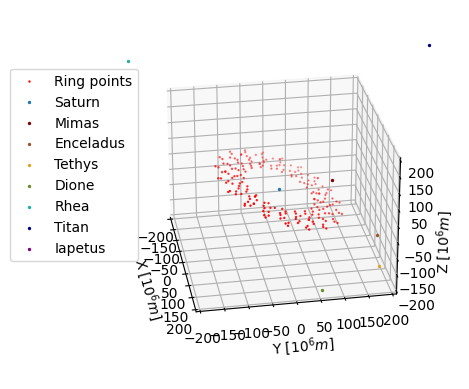

<Figure size 640x480 with 0 Axes>

In [5]:
from matplotlib.animation import FuncAnimation
from IPython import display



#print(XsnRingRArray[1])
print(XtList[-1])

def plot1(index):
    halfBoxLength = 200
    plotLims = [-halfBoxLength,halfBoxLength,-halfBoxLength,halfBoxLength,-halfBoxLength,halfBoxLength]

    XRArray = XRingRArray
    XSaturnPos = XsnSaturnArray[index][0]
    XMoonsPos = XsnMoonsArray[index]
    ax = plt.figure().add_subplot(projection='3d')
    ax.scatter(XRArray[0], XRArray[1], XRArray[2], s=0.5, label='Ring points',color='red')
    ax.scatter(*XSaturnPos, s = 2, label='Saturn')
    names = MoonsDict.get('name')
    colors = MoonsDict.get('color')
    for i in range(len(colors)):
        ax.scatter(*XMoonsPos[i][0:3], s = 2, label=names[i], color=colors[i])
    ax.legend(loc=4, bbox_to_anchor=(0.15,0.3))
    ax.set_xlabel('X [$10^6 m$]')
    ax.set_ylabel('Y [$10^6 m$]')
    ax.set_zlabel('Z [$10^6 m$]')
    set_axes_equal(ax)
    ax.set_xlim3d([plotLims[0], plotLims[1]])
    ax.set_ylim3d([plotLims[2], plotLims[3]])
    ax.set_zlim3d([plotLims[4], plotLims[5]])
    ax.view_init(27,-10)
    ax.dist = 12
    fig = plt.figure()
    #plt.show()
    #plt.savefig('ring'+str(index))
    return fig

print(np.shape(XRingRArray))

#elev: 27, azim: -10, roll: 0
test = plot1(59)
plt.show()
# for i in range(60):
#     plot1(i)


(60, 7, 3)
81200.0


TypeError: cannot unpack non-iterable Path3DCollection object

<Figure size 640x480 with 0 Axes>

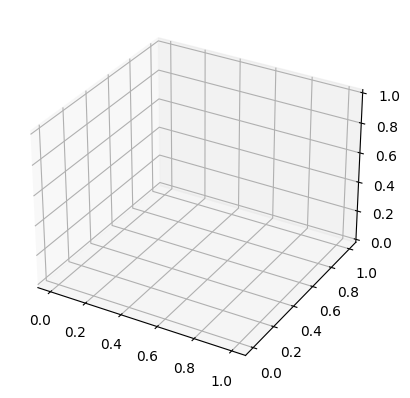

In [11]:
#print(XsnRingRArray[1])
print(np.shape(XsnMoonsArray))
print(XtList[-1])

halfBoxLength = 200
plotLims = [-halfBoxLength,halfBoxLength,-halfBoxLength,halfBoxLength,-halfBoxLength,halfBoxLength]
index = 59
indices = np.arange(0,60)


names = MoonsDict.get('name')
colors = MoonsDict.get('color')

fig = plt.figure()
ax = plt.figure().add_subplot(projection='3d')
l1, = ax.scatter([], [], [], s=0.5, label='Ring points',color='red')
l2, = ax.scatter([], [], [], s = 2, label='Saturn')


ax.legend(bbox_to_anchor=(0.1,0.7))
ax.set_xlabel('X [$10^6 m$]')
ax.set_ylabel('Y [$10^6 m$]')
ax.set_zlabel('Z [$10^6 m$]')
set_axes_equal(ax)
ax.set_xlim3d([plotLims[0], plotLims[1]])
ax.set_ylim3d([plotLims[2], plotLims[3]])
ax.set_zlim3d([plotLims[4], plotLims[5]])
ax.view_init(27,-10)
ax.dist = 12
plt.show()
#elev: 27, azim: -10, roll: 0

anim = animation.FuncAnimation(fig, animate, frames=4,  
                               interval=100, blit=True) 
#fig.suptitle('Sine wave plot', fontsize=14) 
  
# converting to an html5 video 
video = anim.to_html5_video() 
  
# embedding for the video 
html = display.HTML(video) 
  
# draw the animation 
display.display(html) 
plt.close() 

"""metadata = dict(title='ringGif', artist='Keira')
writer = PillowWriter(fps=20, metadata=metadata)


with writer.saving(fig, 'ringOrbit.gif',200):
    for i in indices:
        XRArray = XsnRingRArray[i]
        XSaturnPos = XsnSaturnArray[i][0]
        XMoonsPos = XsnMoonsArray[i]

        ax.scatter(XRArray[0], XRArray[1], XRArray[2], s=0.5, label='Ring points',color='red')
        ax.scatter(*XSaturnPos, s = 2, label='Saturn')
        for i in range(len(colors)):
            ax.scatter(*XMoonsPos[i][0:3], s = 2, label=names[i], color=colors[i])
        writer.grab_frame()"""

In [ ]:
#print(XsnRingRArray[1])

indices = np.arange(0,60)

def SavePlot1(index):
    halfBoxLength = 200
    plotLims = [-halfBoxLength,halfBoxLength,-halfBoxLength,halfBoxLength,-halfBoxLength,halfBoxLength]

    XRArray = XsnRingRArray[index]
    XSaturnPos = XsnSaturnArray[index][0]
    XMoonsPos = XsnMoonsArray[index]
    names = MoonsDict.get('name')
    colors = MoonsDict.get('color')

    ax = plt.figure().add_subplot(projection='3d')
    ax.scatter(XRArray[0], XRArray[1], XRArray[2], s=0.5, label='Ring points',color='red')
    ax.scatter(*XSaturnPos, s = 2, label='Saturn')
    for i in range(len(colors)):
        ax.scatter(*XMoonsPos[i][0:3], s = 2, label=names[i], color=colors[i])

    ax.legend(bbox_to_anchor=(-0.2,0.6), loc=6)
    ax.set_xlabel('X [$10^6 m$]')
    ax.set_ylabel('Y [$10^6 m$]')
    ax.set_zlabel('Z [$10^6 m$]')
    set_axes_equal(ax)
    ax.set_xlim3d([plotLims[0], plotLims[1]])
    ax.set_ylim3d([plotLims[2], plotLims[3]])
    ax.set_zlim3d([plotLims[4], plotLims[5]])
    ax.view_init(27,-10)
    ax.dist = 12
    #plt.show()
    plt.savefig('rings'+str(index))

    return None
def SavePlot2(index):
    
    return None

#SavePlot1(2)
for i in indices:
    #SavePlot1(i)
    #elev: 27, azim: -10, roll: 0

In [ ]:
def ODESolve(t_0, t_f, dt, initBool, initModeTuple=None, progress='none'):
    match initBool:
        case True:
            init(initModeTuple)
        case False:
            pass
            

In [6]:
import os


In [74]:
'''print(os.listdir())
print('current working directory: {}'.format(os.getcwd()))
os.chdir('Ephemeris Data')'''
print(os.listdir())
print(os.getcwd())


['dione_horizons_results.txt', 'enceladus_horizons_results.txt', 'iapetus_horizons_results.txt', 'mimas_horizons_results.txt', 'rhea_horizons_results.txt', 'saturn_horizons_results.txt', 'tethys_horizons_results.txt', 'titan_horizons_results.txt']
c:\Users\Kenneth\Desktop\Stuff\Documents\Study\Durham\L3\3561 CPr\CPr-3BodyProblem\Ephemeris Data


In [103]:
separatorsList = [' X =', ' Y =', ' Z =', ' VX=', ' VY=', ' VZ=', ' LT=', ' RG=', ' RR=']
namesList = ['Mimas', 'Enceladus', 'Tethys', 'Dione', 'Rhea', 'Titan', 'Iapetus']
elements = []

def readElements(name, mode): #Reads orbital elements out of a Horizons Ephemeris txt file
    file = open(name + '_horizons_results.txt', 'r')
    print(name + '.txt')
    outputlist = []
    contents = file.read()
    for i in range(len(separatorsList) - 1):
        temporary = contents
        temporary = temporary.split(separatorsList[i], mode)[mode]
        temporary = temporary.split(separatorsList[i+1], mode)[0]
        temporary = temporary.rstrip().lstrip()
        temporary = temporary.casefold()
        temporary = float(temporary)
        outputlist.append(temporary)
    temporary = contents
    temporary = temporary.split(separatorsList[-1], 2)[1]
    temporary = temporary[0:22]
    temporary = temporary.rstrip().lstrip()
    temporary = temporary.casefold()
    temporary = float(temporary)
    print(temporary)
    outputlist.append(temporary)

    #print(outputlist)
    return outputlist
'''for name in namesList:
    elements.append(readElements(name,1))
elements = np.array(elements)
print(elements)
elements = elements/1e3
print(repr(elements) == repr(MoonsDict.get('elements')))'''

elements = np.zeros((2,9))
elements[0] = np.array(readElements('Aegaeon',1))
elements[1] = np.array(readElements('Aegaeon',2))
print(repr(elements))

'''x = np.array(readElements('saturn'))
print(x)
x = x/1e3
print(x)
print(repr(x))'''


Aegaeon.txt
-0.02302498160477574
Aegaeon.txt
-0.02302498160477574
array([[ 1.62925749e+05,  2.62721373e+04, -2.95455149e+04,
        -3.33490571e+00,  1.31494109e+01, -6.56677155e+00,
         5.59234531e-01,  1.67654295e+05, -2.30249816e-02],
       [-2.38713706e+04,  1.47623071e+05, -7.50370575e+04,
        -1.48591023e+01, -1.34028152e+00,  2.14131733e+00,
         5.58089452e-01,  1.67311008e+05, -2.30249816e-02]])


"x = np.array(readElements('saturn'))\nprint(x)\nx = x/1e3\nprint(x)\nprint(repr(x))"

In [28]:
x0 = np.array([1,2,3])
x1 = np.array([np.cos(x0), np.sin(x0), np.zeros(len(x0))])
x1 = np.transpose(x1)

print(x1)
print(x1[1])
print(MoonsDict.get('elements')[0])

[[ 0.54030231  0.84147098  0.        ]
 [-0.41614684  0.90929743  0.        ]
 [-0.9899925   0.14112001  0.        ]]
[-0.41614684  0.90929743  0.        ]
[-1.12774495e+02  1.37769404e+02 -6.15442605e+01 -1.11522197e-02
 -7.32502779e-03  4.48190526e-03  6.28360667e-04  1.88377789e+02
 -1.44997560e-04]


In [ ]:
x0 = np.linspace(0,2*np.pi, 10)
x2 = np.zeros((3,0))
for i in range(5):
    x1 = np.array([np.cos(x0),np.sin(x0),np.zeros(len(x0))])
    print(np.shape(x2))
    print(np.shape(x1))
    x2 = np.append(x2, np.array(x1),1)
print(x2)

In [ ]:
x = np.zeros((3,0))
print(x)
for i in range(5):  
    x = np.append(x, np.transpose(np.array([[1,2,3]])),1)
    print(x)

In [16]:
x1 = ConstantsDict.get('AegaeonElements')[0][0:3]
x2 = ConstantsDict.get('AegaeonElements')[1][0:3]

x1 = x1/np.sqrt(np.dot(x1,x1))
x2 = x2/np.sqrt(np.dot(x2,x2))
print(x1)
print(x2)
angle0 = np.arccos(np.dot(x1, x2)/np.sqrt(np.dot(x1,x1))/np.sqrt(np.dot(x1,x1)))
print('angle0: {} rads, {} degs'.format(angle0, angle0/np.pi*180))
normalVector = np.cross(x1, x2)
print('normalVector: {}'.format(normalVector))
angle = np.arccos(np.dot(normalVector, [0,0,1])/np.sqrt(np.dot(normalVector,normalVector)))
print('angle: {} rads, {} degs'.format(angle, angle/(np.pi)*180))
node = np.cross(normalVector, [0,0,1])
node = node/np.sqrt(np.dot(node, node))
print('node vector:{}'.format(node))

[ 0.97179586  0.15670423 -0.1762288 ]
[-0.14267663  0.88232731 -0.44848847]
angle0: 1.4920665703374594 rads, 85.48911723289602 degs
ringPlaneVector: [0.08521144 0.46098297 0.87980005]
angle: 0.4895729056668093 rads, 28.05046125866456 degs
node vector:[ 0.98334145 -0.18176798  0.        ]


In [16]:
p = np.array([0.9424218, 1.370218, 1.887802, 2.736915, 4.518212, 15.945421, 79.33])
p = p*86164.091
print(repr(p))
print(MoonsDict.get('name'))

array([  81202.91773558,  118063.58844184,  162660.74331798,
        235823.79311927,  389307.62992529, 1373922.70607731,
       6835397.33903   ])
['Mimas', 'Enceladus', 'Tethys', 'Dione', 'Rhea', 'Titan', 'Iapetus']


In [15]:
x0 = ConstantsDict.get('Gravitational Constant')
x1 = ConstantsDict.get('Saturn Mass')
x2 = 81202.91773558
res1 = np.cbrt(x0*x1*x2**2/(4*np.pi**2))
print('{}'.format(res1))
print('in Mm: {}'.format(res1*1e-4))
y0 = x0
y1 = x1*1e6
y2 = x2
print(np.cbrt(y0*y1*y2**2/(4*np.pi**2)))

1850243.7619752712
in Mm: 185.02437619752712
185024376.1975271


In [76]:
x0 = np.array([1,2,3])
x0 = [x0]
x1 = np.zeros((0,3))
for i in range(5):
    print(np.shape(x0))
    print(np.shape(x1))
    x1 = np.append(x1,x0,0)
    print(x1)

(1, 3)
(0, 3)
[[1. 2. 3.]]
(1, 3)
(1, 3)
[[1. 2. 3.]
 [1. 2. 3.]]
(1, 3)
(2, 3)
[[1. 2. 3.]
 [1. 2. 3.]
 [1. 2. 3.]]
(1, 3)
(3, 3)
[[1. 2. 3.]
 [1. 2. 3.]
 [1. 2. 3.]
 [1. 2. 3.]]
(1, 3)
(4, 3)
[[1. 2. 3.]
 [1. 2. 3.]
 [1. 2. 3.]
 [1. 2. 3.]
 [1. 2. 3.]]


In [36]:
deltaT = 1.4
tFinal = 15.6
Nsteps = int((tFinal/deltaT))
print(Nsteps)

x = np.arange(0,tFinal,deltaT)
print(x)

numberofSnapshots = 5
snapshotInterval = tFinal/numberofSnapshots
y = np.linspace(0,tFinal,numberofSnapshots)
y0 = y/deltaT
y1 = np.round(y/deltaT)
print(y)
print(y0)
print(y1)

11
[ 0.   1.4  2.8  4.2  5.6  7.   8.4  9.8 11.2 12.6 14.  15.4]
[ 0.   3.9  7.8 11.7 15.6]
[ 0.          2.78571429  5.57142857  8.35714286 11.14285714]
[ 0.  3.  6.  8. 11.]


1
1


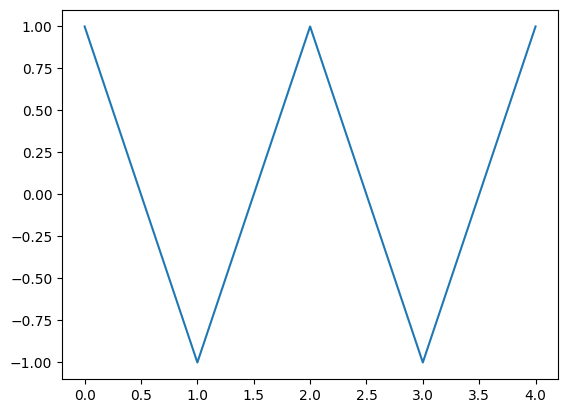

In [13]:
fig = plt.figure()
ax = plt.axes()
lines = {
    'line1': ax.plot([0,1,2,3,4],[1,-1,1,-1,1])[0]
}
x0 = np.array([[0,1,2,3],[4,5,6,7]])
print(x0[0,1])
print(x0[0][1])